In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from math import log
import numpy as np
from sklearn.preprocessing import normalize

In [2]:
data = pd.read_pickle("../data/processed/supply_and_demand_order_level.pkl")
data

,kingdom,phylum,class,order,nr_authors,taxonomicResearchNeeded,cropWildRelatives,horizonInvasives
0,Plantae,Tracheophyta,Magnoliopsida,Lamiales,1412.0,40.0,99.0,20.0
1,Plantae,Marchantiophyta,Jungermanniopsida,Porellales,29.0,6.0,0.0,0.0
2,Animalia,Arthropoda,Insecta,Diptera,2023.0,110.0,0.0,0.0
3,Animalia,Arthropoda,Insecta,Hemiptera,1305.0,0.0,0.0,0.0
4,Animalia,Arthropoda,Maxillopoda,Sessilia,26.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1588,Fungi,Ascomycota,Archaeorhizomycetes,Archaeorhizomycetales,0.0,0.0,0.0,0.0
1589,Animalia,Annelida,Clitellata,Capilloventrida,4.0,0.0,0.0,0.0
1590,Chromista,Cryptophyta,Cryptophyceae,NaN,0.0,0.0,0.0,0.0
1591,Animalia,Arthropoda,Trilobita,Proparia,0.0,0.0,0.0,0.0


In [3]:
plants = data[data["kingdom"]=="Plantae"]
animals = data[data["kingdom"]=="Animalia"]
fungi = data[data["kingdom"]=="Fungi"]

In [4]:
def scatter_supply_single_demand(df, demand, col="blue",
                                 logx=False, logy=False, 
                                 nozerosy=False, trendline=False, 
                                 xmin=0, ymin=0):
    # SET X AND Y
    if nozerosy: # removes data points with and y=0
        df = df[df[demand]!=0]
        
    if logx: 
        x = np.log(list(df["nr_authors"]+1))
        xlabel = "log(Researchers + 1)"
    else: 
        x = list(df["nr_authors"])
        xlabel = "Researchers"
        
    if logy: 
        y = np.log(list(df[demand]+1))
        ylabel = "log("+demand+" + 1)"
    else: 
        y = list(df[demand])
        ylabel = demand
    
    # PLOT
    fig, ax = plt.subplots()
    ax.scatter(x,y,c=col)
    
    if trendline:
        z = np.polyfit(x,y,1)
        p = np.poly1d(z)
        plt.plot(x, p(x),col)
    
    # add labels 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    for i, txt in enumerate(df["order"]):
        if x[i] >= xmin and y[i] >= ymin:
            ax.annotate(txt, (x[i],y[i]),
                        ha="left", rotation=30, fontsize=7)

In [5]:
def scatter_combined_demand(df, demands, col="blue",
                            logx=False, nozeros=False, trendline=False,
                            xmin=0, ymin=0):
    # SET X AND Y
    if nozeros: # removes data points with both x=0 and y=0
        df = df[["order", "nr_authors", demand]].loc[(df!=0).any(axis=1)]
    
    # x: logged or not
    if logx: 
        x = np.log(list(df["nr_authors"]+1))
        xlabel = "log(Researchers + 1)"
    else: 
        x = list(df["nr_authors"])
        xlabel = "Researchers"
    
    # y: combined normalized demands
    comb_demands = len(df)*[0,]
    for demand in demands:
        norm_demand = normalize([df[demand]])[0]
        comb_demands = [comb_demands[i] + norm_demand[i] for i in range(len(comb_demands))]
    
    y = comb_demands
    
    # PLOT
    fig, ax = plt.subplots()
    ax.scatter(x,y,c=col)
    
    if trendline:
        z = np.polyfit(x,y,1)
        p = np.poly1d(z)
        plt.plot(x, p(x))
        
    # add labels 
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Combined normalized demands")
    
    for i, txt in enumerate(df["order"]):
        if x[i] >= xmin and y[i] >= ymin:
            ax.annotate(txt, (x[i],y[i]),
                        ha="left", rotation=30, fontsize=7)

# Plants

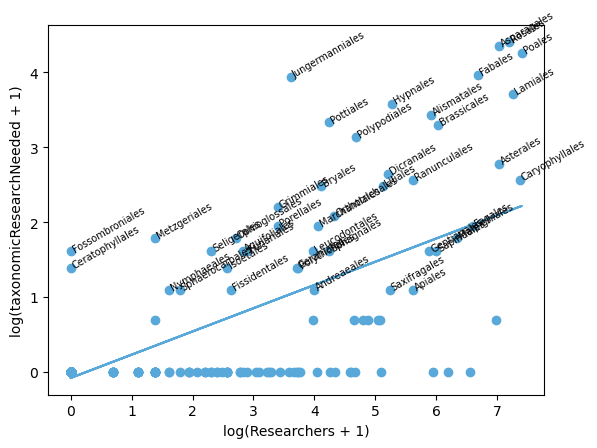

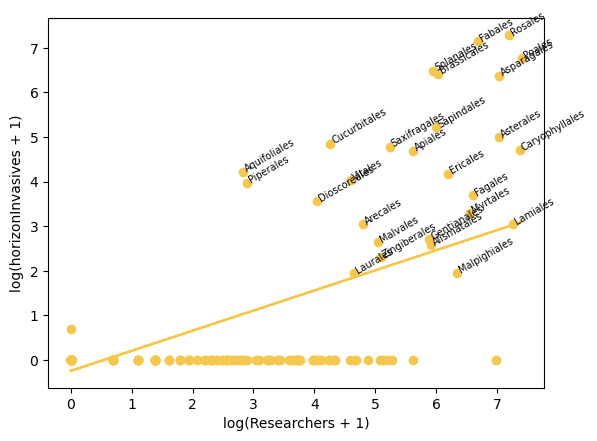

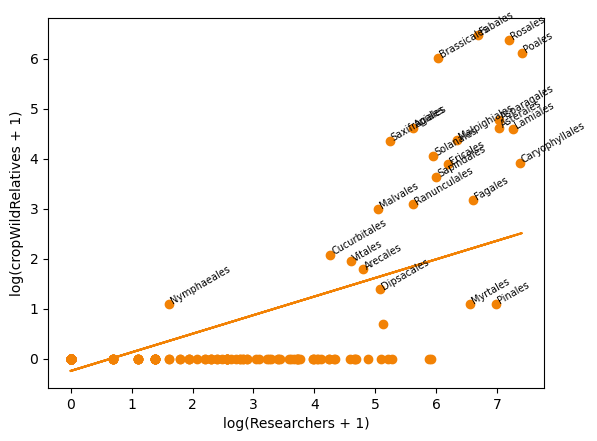

In [6]:
for i, demand in enumerate(["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives"]):
    color = ["#58A9D9", "#F6C74F", "#F28205"][i]
    scatter_supply_single_demand(plants, demand, col=color,
                                 logx=True, logy=True,
                                 trendline=True,
                                 ymin=1)

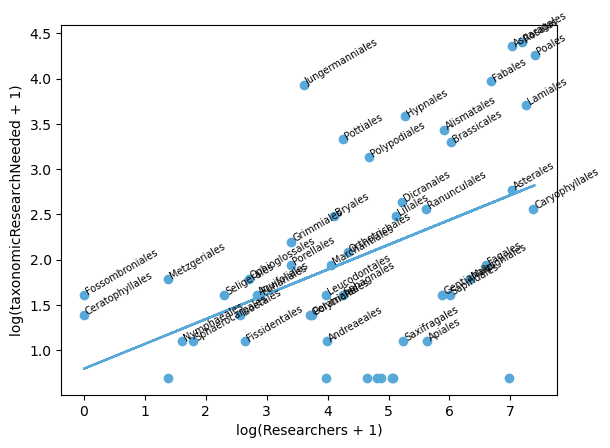

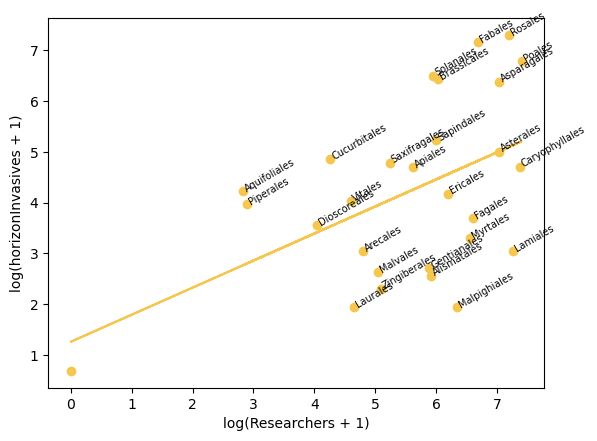

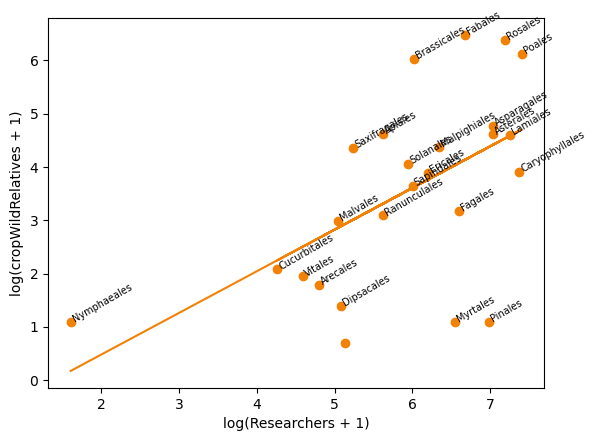

In [7]:
for i, demand in enumerate(["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives"]):
    color = ["#58A9D9", "#F6C74F", "#F28205"][i]
    scatter_supply_single_demand(plants, demand, col=color,
                                 logx=True, logy=True, nozerosy=True,
                                 trendline=True,
                                 ymin=1)

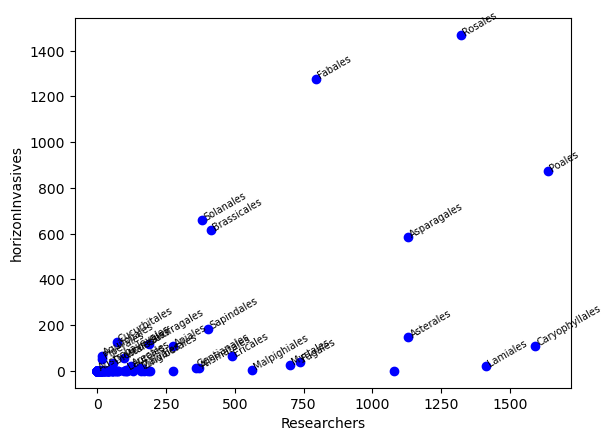

In [8]:
scatter_supply_single_demand(plants, "horizonInvasives", logx=False, ymin=1)

Text(0, 0.5, 'Normalized demands')

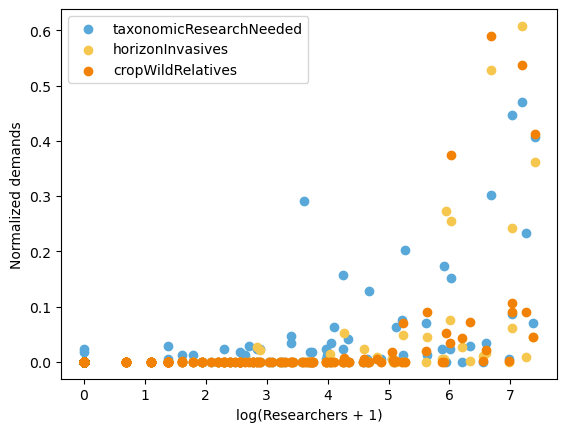

In [9]:
x = np.log(list(plants["nr_authors"]+1))
fig, ax = plt.subplots()
for i, demand in enumerate(["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives"]):
    color = ["#58A9D9", "#F6C74F", "#F28205"][i]
    y = normalize([list(plants[demand])])
    ax.scatter(x,y,c=color)
ax.legend(["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives"])
ax.set_xlabel("log(Researchers + 1)")
ax.set_ylabel("Normalized demands")

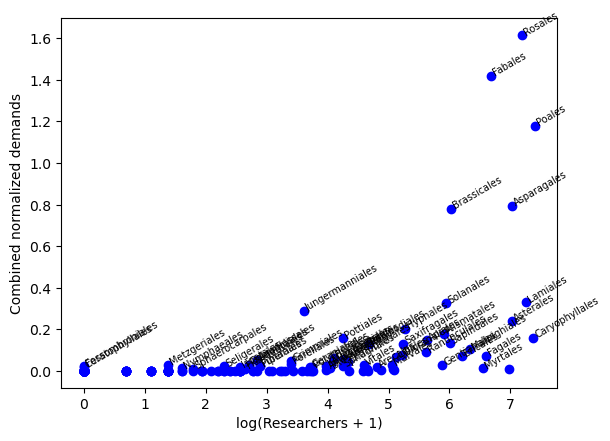

In [10]:
scatter_combined_demand(plants, ["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives"],
                        logx=True, ymin=0.01)

# Animals

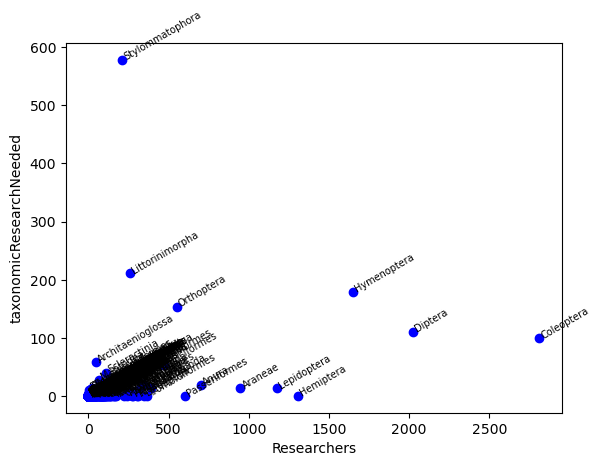

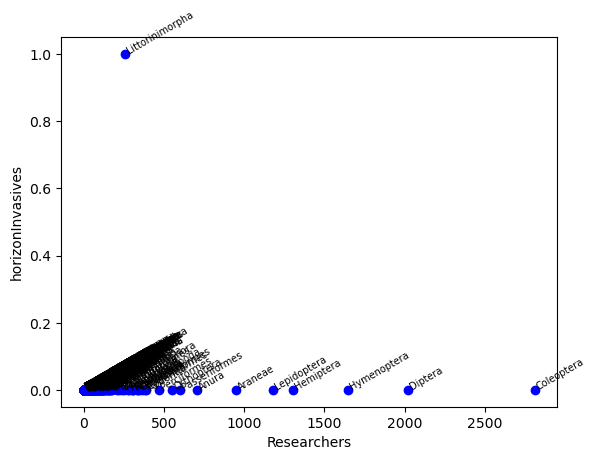

In [11]:
for demand in ["taxonomicResearchNeeded", "horizonInvasives"]:
    scatter_supply_single_demand(animals, demand)

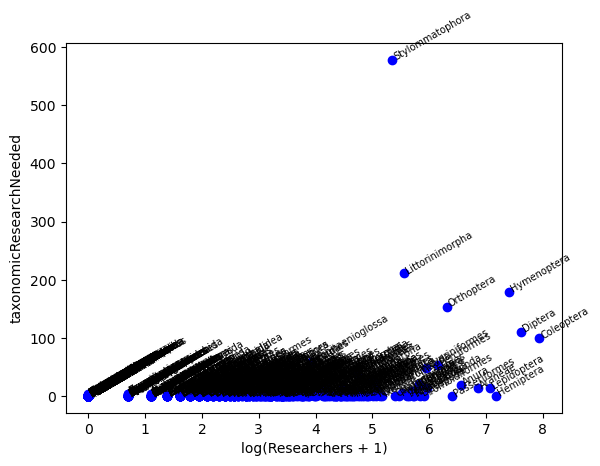

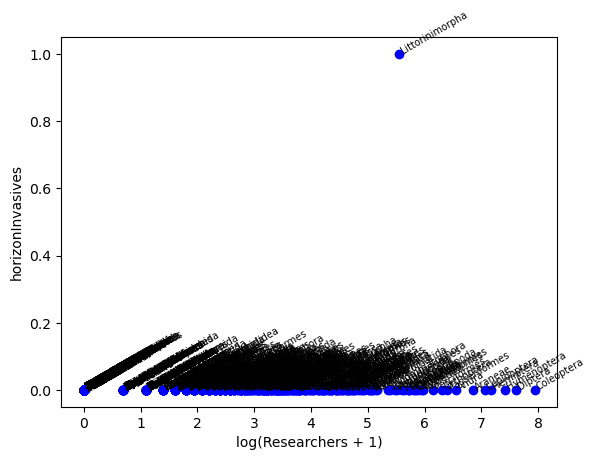

In [13]:
for demand in ["taxonomicResearchNeeded", "horizonInvasives"]:
    scatter_supply_single_demand(animals, demand, logx=True)

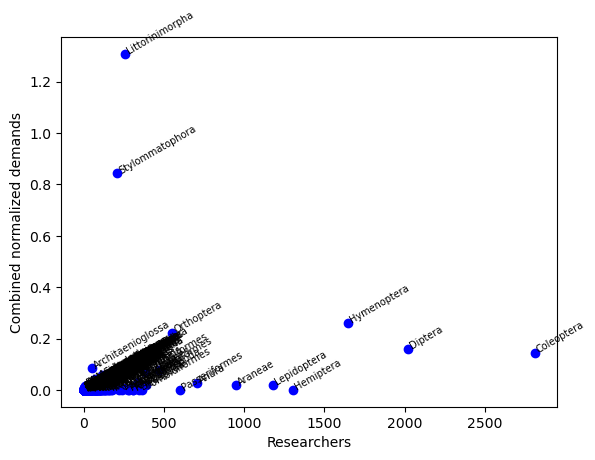

In [14]:
scatter_combined_demand(animals, ["taxonomicResearchNeeded", "horizonInvasives"])

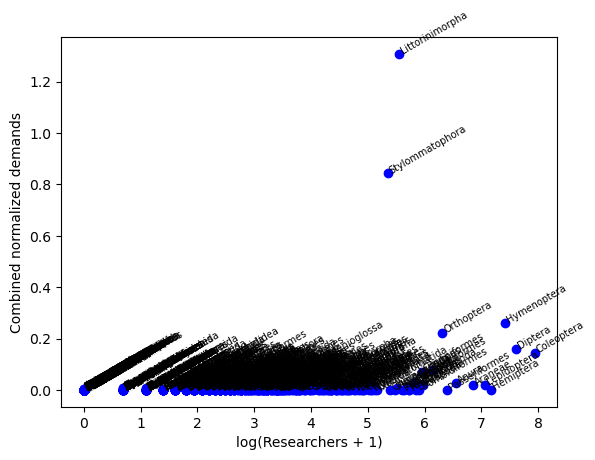

In [16]:
scatter_combined_demand(animals, ["taxonomicResearchNeeded", "horizonInvasives"],
                       logx=True)

# Fungi

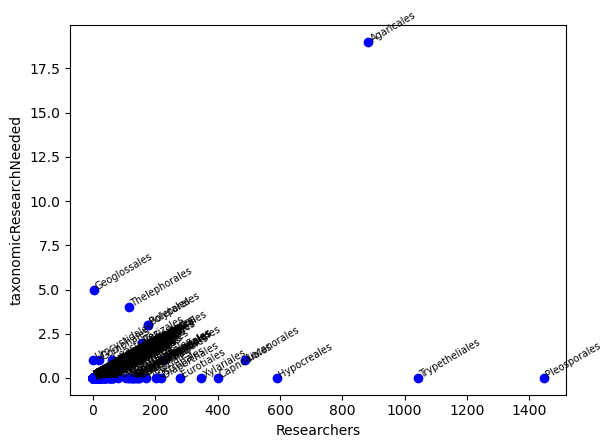

In [17]:
scatter_supply_single_demand(fungi, "taxonomicResearchNeeded")

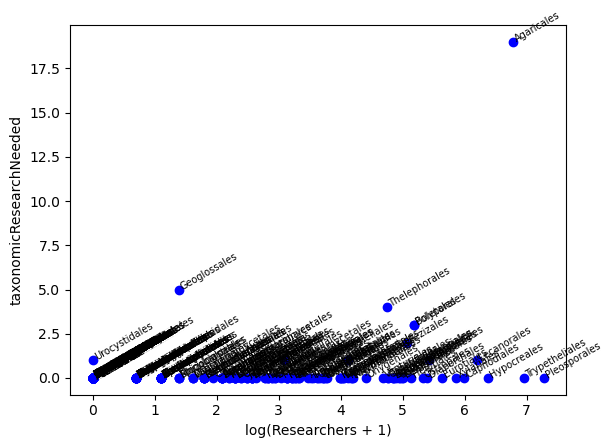

In [18]:
scatter_supply_single_demand(fungi, "taxonomicResearchNeeded", 
                             logx=True)